In [1]:
import time
import sys
import os
from collections import OrderedDict
from importlib import reload
from pprint import pprint

import math
import h5py
import numpy as np
from matplotlib import pyplot as plt

%matplotlib notebook

In [2]:
import qcodes
qc = qcodes

In [3]:
from stationq.mplplots.init_nb_plotting import *
from stationq.mplplots import plots as mplplots
from stationq.mplplots import tools as mpltools

In [52]:
def id(x):
    # This function returns the memory
    # block address of an array.
    return x.__array_interface__['data'][0]

In [4]:
%run init.py

2018-01-17 13:43:51,663 : measurement : INFO : Logger set up!
C:\Users\Administrator\Code\Qcodes\qcodes\instrument\parameter.py:182: UserWarning: Delay kwarg is deprecated. Replace with inter_delay or post_delay as needed
  warnings.warn("Delay kwarg is deprecated. Replace with "


Initialized IVVI-rack in 0.13s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110525, firmware:3.1.19.15-3.50.124.67) in 0.02s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110524, firmware:3.1.19.15-3.50.124.67) in 0.02s
Connected to: TEKTRONIX AWG5014C (serial:B051388, firmware:SCPI:99.0 FW:4.6.0.7) in 0.06s
Connected to: Rigol Technologies DG4062 (serial:DG4E163251554, firmware:00.01.09) in 0.05s


C:\Users\Administrator\Code\Qcodes\qcodes\instrument\parameter.py:512: UserWarning: set_step is deprecated use step property as in `inst.step = stepvalue` instead
  "set_step is deprecated use step property as in `inst.step = "
C:\Users\Administrator\Code\Qcodes\qcodes\instrument\parameter.py:524: UserWarning: set_delay is deprecated use inter_delay or post_delay property as in `inst.inter_delay = delayvalue` instead
  "set_delay is deprecated use inter_delay or post_delay property "


In [5]:
from stationq.data.data_storage import Data, GridData
Data.export_spyview = True
GridData.export_spyview = True

In [6]:
t1, t2, t3 = int(station.ivvi.dac4()), int(station.ivvi.dac5()), int(station.ivvi.dac6())
t1, t2, t3

(-879, -590, -877)

In [293]:
from qcodes.instrument_drivers.AlazarTech.ATS import AcquisitionController
import time

class AcquisitionControllerExt(AcquisitionController):
    
    ZERO = np.int16(2048)
    RANGE = 2047.5

    def __init__(self, name, alazar_name, **kwargs):
        self.acquisitionkwargs = {}
        self.sample_rate = None
        self.samples_per_record = None
        self.records_per_buffer = None
        self.buffers_per_acquisition = None
        self.number_of_channels = 2
        # self.buffer = None
        self.trigger_func = None
        self.demod_frq = None
        
        # make a call to the parent class and by extension, create the parameter
        # structure of this class
        super().__init__(name, alazar_name, **kwargs)
        self.add_parameter("acquisition", get_cmd=self.do_acquisition)
        
    def pre_start_capture(self):
        alazar = self._get_alazar()
        self.sample_rate = alazar.sample_rate()
        self.samples_per_record = alazar.samples_per_record.get()
        self.records_per_buffer = alazar.records_per_buffer.get()
        self.buffers_per_acquisition = alazar.buffers_per_acquisition.get()
        
        self.data_shape = (self.buffers_per_acquisition,
                           self.records_per_buffer,
                           # self.samples_per_record,
                           self.number_of_channels)
        self.buffer_shape = (self.records_per_buffer,
                             self.samples_per_record,
                             self.number_of_channels)
        
        self.buffer = np.zeros(self.data_shape)
        self.data_real = np.zeros(self.data_shape, dtype=np.float32)
        self.data_imag = np.zeros(self.data_shape, dtype=np.float32)
        
        _t = np.arange(self.samples_per_record, dtype=np.float32)/self.sample_rate
        self.cosarr = (np.cos(2*np.pi*self.demod_frq*_t).reshape(1,-1,1)) # .astype(np.int16)
        self.sinarr = (np.sin(2*np.pi*self.demod_frq*_t).reshape(1,-1,1)) # .astype(np.int16)
        
        self.handling_times = np.zeros(self.buffers_per_acquisition, dtype=np.float64)
    
    
    def pre_acquire(self):
        if self.trigger_func:
            self.trigger_func(True)
            
        
    def post_acquire(self):
        if self.trigger_func:
            self.trigger_func(False)
            
        return self.data_real + 1j * self.data_imag
    
    
    def handle_buffer(self, data, buffer_number=None):
        """
        See AcquisitionController
        :return:
        """
        t0 = time.perf_counter()
        
        shaped_data = data.reshape(self.buffer_shape).view(np.uint16)
        shaped_data >>= 4
        shaped_data = shaped_data.view(np.int16)
        shaped_data -= self.ZERO
        
        real_data = np.tensordot(shaped_data, self.cosarr, axes=(-2, -2)).reshape(self.records_per_buffer, 2) / 2047.5 / self.samples_per_record
        imag_data = np.tensordot(shaped_data, self.sinarr, axes=(-2, -2)).reshape(self.records_per_buffer, 2) / 2047.5 / self.samples_per_record
        
        if not buffer_number:
            self.data_real += real_data
            self.data_imag += imag_data
            self.handling_times[0] = (time.perf_counter() - t0) * 1e3
        else:
            self.data_real[buffer_number] = real_data
            self.data_imag[buffer_number] = imag_data
            self.handling_times[buffer_number] = (time.perf_counter() - t0) * 1e3
            
    
    def update_acquisitionkwargs(self, **kwargs):
        """
        This method must be used to update the kwargs used for the acquisition
        with the alazar_driver.acquire
        :param kwargs:
        :return:
        """
        self.acquisitionkwargs.update(**kwargs)
    
    
    def do_acquisition(self):
        """
        this method performs an acquisition, which is the get_cmd for the
        acquisiion parameter of this instrument
        :return:
        """
        value = self._get_alazar().acquire(acquisition_controller=self, **self.acquisitionkwargs)
        return value

In [294]:
from stationq.qctools import instruments as instools

ctl = instools.create_inst(AcquisitionControllerExt, 'ctl', 'alazar', force_new_instance=True)

Instrument ctl already exists.


In [1]:
namespace.ats_settings['sample_rate'] = int(1e8)
namespace.ats_settings['trigger_source1'] = 'EXTERNAL'
namespace.ats_settings['timeout_ticks'] = 10 * int(1e6)
station.alazar.config(**namespace.ats_settings)
station.RF.frequency(538.2e6)
station.RF.power(-25)
# station.RF.frequency(1.398e9)
# station.RF.power(-40)
station.LO.frequency(538.2e6+8e6)
station.LO.power(22)

station.fg.ch1_frequency(1)
station.fg.ch1_output_enabled(False)

NameError: name 'namespace' is not defined

In [308]:
ctl.update_acquisitionkwargs(samples_per_record=50*128,
                             records_per_buffer=80, 
                             buffers_per_acquisition=160, 
                             buffer_timeout=10000,
                             allocated_buffers=160)
ctl.demod_frq = 8e6

In [309]:
data = ctl.acquisition()
print(data.shape)
print(station.alazar.buffers_per_acquisition())
print(station.alazar.allocated_buffers())

(160, 80, 2)
160
160


<IPython.core.display.Javascript object>


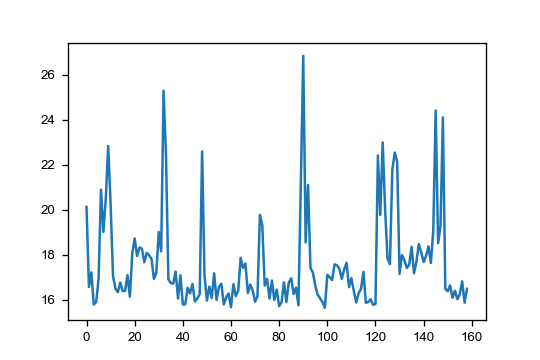

In [310]:
fig, ax = plt.subplots(1,1)
ax.plot(ctl.handling_times[1:])

In [285]:
# f = 8e6
# spr = ctl.samples_per_record
# tvals = (np.arange(spr, dtype=np.float32)) / ctl.sample_rate
# cosarr = np.cos(2*np.pi*f*tvals).reshape(1, 1, -1, 1) / 2048
# sinarr = np.sin(2*np.pi*f*tvals).reshape(1, 1, -1, 1) / 2048
# print(cosarr.shape)
# demoddata = (np.multiply(cosarr, data) + 1j * np.multiply(sinarr, data)).astype(np.complex64)
# demodmean = demoddata.mean(axis=2)
# mag = abs(demodmean)
# phase = np.angle((demodmean[...,0]*demodmean[...,1].conj()), deg=True)